In [1]:
import numpy as np
import gym
import os 
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from environment import Vasuki


In [16]:
Train = True
gamma = 0.99
copy_step = 250
max_experiences = 1000000
min_experiences = 20000
Steps_Till_Backprop = 64
batch_size = 512
lr = 2.5e-4
epsilon = 0.99
decay = 0.999
min_epsilon = 0.1
episodes = 1000 #Set this to longer
Metric_Titles = ['RewardA','RewardB','Score']


Note the tanh output layer which restricts output to \[-1,1\]

In [17]:
class DQN:
    def __init__(self, num_states, num_actions, gamma, max_experiences, min_experiences, batch_size, lr,model):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.optimizer = tf.keras.optimizers.Nadam(lr)
        self.gamma = gamma
        if model != None:
            self.model = tf.keras.models.load_model("model.h5")
        self.model = self.rl_model()
        self.experience = {'inputs': [], 'a': [], 'r': [], 'inputs2': []} # The buffer
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences

    #@tf.function
    def train(self):
        # Only start the training process when we have enough experiences in the buffer
        if len(self.experience['inputs']) < self.min_experiences:
            return 0

        # Randomly select n experience in the buffer, n is batch-size
        ids = np.random.randint(low=0, high=len(self.experience['inputs']), size=self.batch_size)
        states = np.asarray([self.experience['inputs'][i] for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])

        # Prepare labels for training process
        states_next = np.asarray([self.experience['inputs2'][i] for i in ids])
        #print(np.shape(states))
        states_next = states_next.astype('float32')
        Next_Q_Values = self.model(states_next.squeeze())
        
        value_next = np.max(Next_Q_Values)
        actual_values = rewards+self.gamma*value_next
        with tf.GradientTape() as tape:
            selected_action_values = tf.math.reduce_sum(
                self.model(states.squeeze()) * tf.one_hot(actions, self.num_actions), axis=1)
            loss = tf.math.reduce_sum(tf.square(actual_values - selected_action_values))
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        
        

    # Get an action by using epsilon-greedy
    def get_action(self, state, epsilon):
        if len(self.experience['inputs']) < self.min_experiences:
            return int(np.random.choice(3))
        if np.random.random() < epsilon:
            return int(np.random.choice(3))
        else:
            prediction = self.model(state)
            return np.argmax(prediction)

    def add_experience(self, exp):
        if len(self.experience['inputs']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    def rl_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(100, activation='relu',
                                  input_shape=[num_states],kernel_initializer='he_normal'),
            tf.keras.layers.Dense(200, activation='relu',kernel_initializer='he_normal'),
            tf.keras.layers.Dense(200, activation='relu',kernel_initializer='he_normal'),
            tf.keras.layers.Dense(100, activation='relu',kernel_initializer='he_normal'),
            tf.keras.layers.Dense(num_actions, activation='tanh',kernel_initializer='RandomNormal')
        ])
        return model

    def copy_weights(self, TrainNet):
        variables1 = self.model.trainable_variables
        variables2 = TrainNet.model.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v1.assign(v2.numpy())

    def save_weights(self, path):
        self.model.save_weights(path)

    def load_weights(self, path):
        ref_model = tf.keras.Sequential()

        ref_model.add(self.model.input_layer)
        for layer in self.model.hidden_layers:
            ref_model.add(layer)
        ref_model.add(self.model.output_layer)

        ref_model.load_weights(path)


    



In [18]:
def get_obs(info,agent,closeFood):
    scoreA = info['agentA']['score']
    scoreB = info['agentB']['score']
    n = 8
    score = 0

    if agent == 'agentA':
        state = info['agentA']['state']
        opp_state = info['agentB']['state']
        head = info['agentA']['head']
        velocity =  info['agentA']['velocity']
        if scoreA>scoreB:
            score = 1
        
    elif agent == 'agentB':
        state = info['agentB']['state']
        opp_state = info['agentA']['state']
        head = info['agentB']['head']
        velocity =  info['agentB']['velocity']
        if scoreB>scoreA:
            score = 1
        
    danger_top = 0
    danger_left = 0
    danger_right = 0
    if head == 0: # North
        if state[1] == velocity - 1:  # Left Wall
            danger_left = 1
        if state[0] == velocity - 1:  # Top Wall
            danger_top = 1
        if state[1] == n-velocity:  # Right Wall
            danger_right = 1
    elif head == 1: # East
        if state[0] == velocity - 1:  # Top Wall
            danger_left = 1
        if state[1] == n-velocity:  # Right Wall
            danger_top = 1
        if state[0] == n-velocity:  # Bottom Wall
            danger_right = 1
    elif head == 2: # South
        if state[1] == n - velocity:  # Right Wall
            danger_left = 1
        if state[0] == n-velocity:  # Bottom Wall
            danger_top = 1
        if state[1] == velocity-1:  # Left Wall
            danger_right = 1
    elif head == 3: # West
        if state[0] == n - velocity:  # Bottom Wall
            danger_left = 1
        if state[1] == velocity-1:  # Left Wall
            danger_top = 1
        if state[0] == velocity-1:  # Top Wall
            danger_right = 1
    opponent_top = 0 
    opponent_bottom = 0
    opponent_left = 0 
    opponent_right = 0
    if opp_state[0] < state[0]:
        opponent_top = 1
    if opp_state[0] > state[0]:
        opponent_bottom = 1
    if opp_state[1] < state[1]:
        opponent_left = 1
    if opp_state[1] > state[1]:
        opponent_right = 1
    food_spawn = env.live_foodspawn_space[closeFood[0]]
    food_top = 0 
    food_bottom = 0
    food_left = 0 
    food_right = 0
    if food_spawn[0] < state[0]:
        food_top = 1
    if food_spawn[0] > state[0]:
        food_bottom = 1
    if food_spawn[1] < state[1]:
        food_left = 1
    if food_spawn[1] > state[1]:
        food_right = 1
    obs = [0] * 16
    obs[head] = 1
    obs[4] = danger_top
    obs[5] = danger_left
    obs[6] = danger_right
    obs[7] = opponent_top
    obs[8] = opponent_bottom
    obs[9] = opponent_left
    obs[10] = opponent_right
    obs[11] = food_top
    obs[12] = food_bottom
    obs[13] = food_left
    obs[14] = food_right
    obs[15] = score

    obs = np.array([obs]).reshape(1,-1)
    return obs


In [19]:
def play_game(env, TrainNet, epsilon, copy_step,turns):
    done = False
    env.reset()
    Metric_Buffer={key:[] for key in Metric_Titles}
    action = {'actionA': 0, 'actionB': 0}
    rewardA, rewardB, done, info = env.step(action)
    closeFoodA = [0,0] # [food_index,distance]
    closeFoodB = [0] # [index] 
    distA = []
    distB = []
    for food_loc in env.live_foodspawn_space:
        distA.append(((((info['agentA']['state'][0] - food_loc[0] )**2) + ((info['agentA']['state'][1]-food_loc[1])**2) )**0.5))
        distB.append(((((info['agentB']['state'][0] - food_loc[0] )**2) + ((info['agentB']['state'][1]-food_loc[1])**2) )**0.5))
    closeFoodA[1] = min(distA)
    closeFoodA[0] = distA.index(closeFoodA[1])
    temp = min(distA)
    closeFoodB[0] = distA.index(temp)
    
    while not done:

        # Using epsilon-greedy to get an action
        observationsA = get_obs(info,'agentA',closeFoodA)
        actionA = TrainNet.get_action(observationsA, epsilon)
        modifiedA, _ = env._movement_(actionA, info['agentA'])
        info['agentA'] = modifiedA
        observationsB = get_obs(info,'agentB',closeFoodB)
        actionB = TrainNet.get_action(observationsB, epsilon)
        action = {'actionA': actionA, 'actionB': actionB}
        
        # Caching the information of current state
        prev_observation = observationsA
        # Take action
        rewardA, rewardB, done, info = env.step(action)
        
        if rewardA != env.rewards['Food'] or rewardA != env.rewards['Movement'] or rewardA != env.rewards['Illegal']:
            if rewardA < 0:
                rewardA = -200
            else:
                rewardA += 50
            
    
        if rewardA == env.rewards['Food'] or rewardB == env.rewards['Food']:
            distA = []
            distB = []
            for food_loc in env.live_foodspawn_space:
                distA.append(((((info['agentA']['state'][0] - food_loc[0] )**2) + ((info['agentA']['state'][1]-food_loc[1])**2) )**0.5))
                distB.append(((((info['agentB']['state'][0] - food_loc[0] )**2) + ((info['agentB']['state'][1]-food_loc[1])**2) )**0.5))
            closeFoodA[1] = min(distA)
            closeFoodA[0] = distA.index(closeFoodA[1])
            temp = min(distB)
            closeFoodB[0] = distB.index(temp)
        else:
            food_spawn = env.live_foodspawn_space[closeFoodA[0]]
            dist = ((((info['agentA']['state'][0] - food_spawn[0] )**2) + ((info['agentA']['state'][1]-food_spawn[1])**2) )**0.5)
            if dist < closeFoodA[1]:
                rewardA += 1
                closeFoodA[1] = dist
        
        observation = get_obs(info,'agentA',closeFoodA)
        # Adding experience into buffer
       
        exp = {'inputs': prev_observation, 'a': actionA,
                'r': rewardA, 'inputs2': observation}
        TrainNet.add_experience(exp)

        TrainNet.train()
        turns += 1
        # if turns%Steps_Till_Backprop==0:
        #     TrainNet.train(TargetNet)
        # if turns%copy_step==0:
        #     # Update the weights of the target model when reaching enough "copy step"
        #     TargetNet.copy_weights(TrainNet)
        Metric_Buffer['RewardA'].append(rewardA)
        Metric_Buffer['RewardB'].append(rewardB)
        Metric_Buffer['Score'].append(info['agentA']['score'])
    results={key:[] for key in Metric_Titles}
    for metric_name in Metric_Titles:
        results[metric_name]=np.mean(Metric_Buffer[metric_name])
    return results,turns


Start the training loop. Note here that we track some metrics (min/max/mean Q values). Although it may be hard to tell from these metrics what constitutes a good agent, tracking them can help you ascertain convergence.

In [20]:
config = {'n': 8, 'rewards': {'Food': 10, 'Movement': 0, 'Illegal': -100},
                  'game_length': 100}
env = Vasuki(**config)

num_states = 16
num_actions = env.action_space.n

Metrics_Buffer = {key:[] for key in Metric_Titles} 
# Initialize models
TrainNet = DQN(num_states, num_actions, gamma, max_experiences, min_experiences, batch_size, lr,None)
# TargetNet = DQN(num_states, num_actions, gamma, max_experiences, min_experiences, batch_size, lr)



In [21]:
#model =  tf.keras.models.load_model("model.h5")

In [22]:
#TrainNet = DQN(num_states, num_actions, gamma, max_experiences, min_experiences, batch_size, lr,model)

In [23]:
if Train:
    pbar = tqdm(range(episodes))
    pbar2 = tqdm()
    turns = 0
    for n in pbar:
        epsilon = max(min_epsilon, epsilon * decay)
        results, turns = play_game(env, TrainNet, epsilon, copy_step,turns)
        for metric_name in Metric_Titles:
            Metrics_Buffer[metric_name].append(results[metric_name])
    TrainNet.model.save('./model.h5')
else:
    TrainNet.load_weights('./model.h5')


0it [3:11:44, ?it/s]1000 [00:00<00:20, 47.77it/s]
100%|██████████| 1000/1000 [34:31<00:00,  2.07s/it]

(-100.0, 100.0)

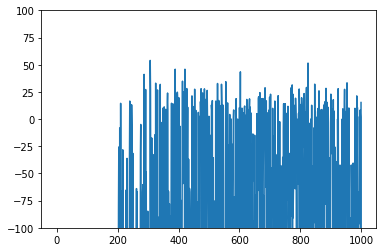

In [24]:
plt.plot(range(1000),
         Metrics_Buffer['Score'], label="B")
plt.ylim(-100, 100)


(-10.0, 10.0)

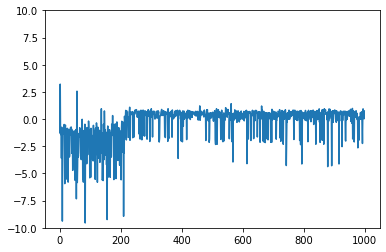

In [83]:
plt.plot(range(1000),
         Metrics_Buffer['RewardA'], label="A")
plt.ylim(-10, 10)

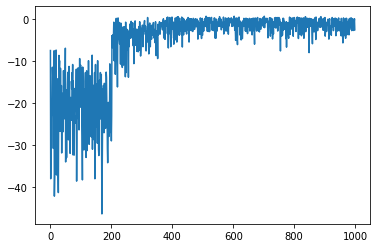

In [25]:
plt.plot(range(1000),
         Metrics_Buffer['RewardB'], label="A")

In [26]:
TrainNet.model.save('./model.h5')
